In [1]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import tensorflow as tf
import keras.backend as K
import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

import pickle
import joblib
from joblib import dump, load

# Data Preprocessing

In [2]:
def preprocessing_data(output_type):
    data_path="dataset/"
    file = "label.csv"
    data=pd.read_csv(data_path+file)
    file_names=list(data['file_name'])
    labels=list(data['label'])
    
    if output_type == 'ohe':
        data['tumor_label'] = data['label'].apply(lambda x: "no_tumor" if x == "no_tumor" else "tumor")
        data = data.drop(columns = ['label'])
        labels=data['tumor_label'].values.reshape(-1,1)
        ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
        labels = ohe.fit_transform(labels)
    
    if output_type == 'binary':
        data['tumor_label'] = data['label'].apply(lambda x: 0 if x == "no_tumor" else 1)
        data = data.drop(columns = ['label'])
        labels=data['tumor_label'].values.reshape(-1,1)
        
    dataset_tumor=[]

    for file_index in range(len(file_names)):
        file=cv2.imread(data_path+"/image/"+file_names[file_index])
        file_resize=cv2.resize(file,(128,128))/255.
        dataset_tumor.append(file_resize)
        
    tumor_data = np.array(dataset_tumor)
    
    return tumor_data, labels

def generate_training_set():
    tumor_data, labels = preprocessing_data('binary')
    x_train,x_test,y_train,y_test = train_test_split(tumor_data,labels,test_size=0.2,random_state=25)
    x_train = x_train.reshape(x_train.shape[0],128*128*3)
    x_test = x_test.reshape(x_test.shape[0],128*128*3)
    y_train = y_train.ravel()
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    joblib.dump(scaler, "Task A Assets/Task_A_Scaler")
    
    return x_train, x_test, y_train, y_test, scaler

In [3]:
x_train, x_test, y_train, y_test, scaler = generate_training_set()

# Training and Validation

## SVM

In [4]:
def SVM():
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    filename = "Task A Assets/Task_A_SVM_Model"
    pickle.dump(clf, open(filename, 'wb'))

In [5]:
model = SVM()

# Testing (using splitted sample data)

In [6]:
def test_model(x_test,y_test):
    filename = "Task A Assets/Task_A_SVM_Model"
    clf = pickle.load(open(filename, 'rb'))
    
    y_pred_svm = clf.predict(x_test)
    print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred_svm)))
    #text report showing the main classification metrics
    print(classification_report(y_test,y_pred_svm))
    plt.figure(figsize = (5,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap = 'Blues')
    plt.show()

Accuracy on test set: 0.955
              precision    recall  f1-score   support

           0       0.92      0.71      0.80        77
           1       0.96      0.99      0.97       523

    accuracy                           0.95       600
   macro avg       0.94      0.85      0.89       600
weighted avg       0.95      0.95      0.95       600



<Figure size 360x360 with 0 Axes>

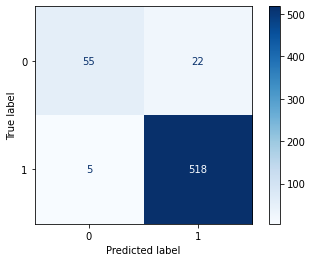

In [7]:
test_model(x_test,y_test)

# Testing (with foreign data)

In [8]:
## make function to graphically show result and label with plot
def test_picture(index):
    test_dataset_tumor=[]
    test_true_labels = []
    test_images = []
    
    data_path = "dataset/"
    
    data=pd.read_csv(data_path+"label.csv")
    rows = len(index)
    index = ["%04d" % x for x in index]
    for i in index:
        file_name = "IMAGE_"+i+".jpg"
        file = cv2.imread(data_path+"image/"+file_name)
        file_resize = cv2.resize(file,(128,128))/255.
        
        plt.figure()
        plt.title(file_name)
        plt.imshow(file_resize)
        true_label = data["label"].loc[data['file_name'] == file_name].apply(lambda x: 0 if x == "no_tumor" else 1).values
        
        test_images.append(file_name)
        test_true_labels.append(true_label[0])
        test_dataset_tumor.append(file_resize)
    
    test_tumor_data = np.array(test_dataset_tumor)
    print(test_tumor_data.shape)
    
    test_tumor_data = test_tumor_data.reshape(rows,128*128*3)
    
    filename = "Task A Assets/Task_A_SVM_Model"
    clf = pickle.load(open(filename, 'rb'))
    
    
    scaler = joblib.load("Task A Assets/Task_A_Scaler")
    test_tumor_data = scaler.transform(test_tumor_data)
    pred_labels = clf.predict(test_tumor_data)
    
    for j in range(rows):
        print("Image: "+ test_images[j] +" ,True label: " + str(test_true_labels[j]) + ", Predicted label: " + str(pred_labels[j]))

(1, 128, 128, 3)
Image: IMAGE_0100.jpg ,True label: 1, Predicted label: 1


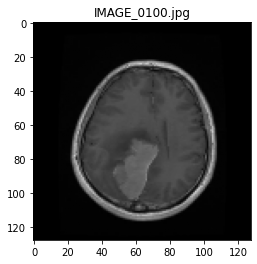

In [9]:
test_picture(range(100,101))